## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.<br>

Цель - построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [2]:
# загружаем и импортируем все библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# загружаем датафрейм с целевым признаком возраст и названием фотографии
df = pd.read_csv('/datasets/faces/labels.csv')
df.info()
df.head()

df.to_csv('labels.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# извлекаем фотографии из папки загрузчиком
datagen = ImageDataGenerator(rescale=1./255)
photos = datagen.flow_from_dataframe(dataframe = df, directory = '/datasets/faces/final_files/', 
                                     x_col='file_name', y_col='real_age', class_mode='raw', 
                                     target_size=(150, 150), batch_size=32, seed=42)

Found 7591 validated image filenames.


In [5]:
# посмотри на статистику распределния возраста в наших данных
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
# посчитаем количество уникальных лет
num_labels = len(np.unique(df['real_age'].values))

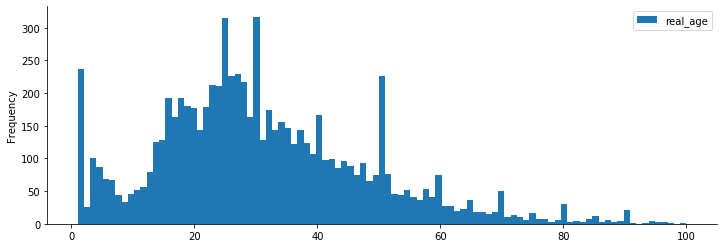

In [7]:
# посмотрим распределение возраста по всей выборке
_ = df.plot(kind='hist', bins=num_labels, figsize=(12,4))
sns.despine()

In [8]:
# получим объекты с парами "картинки-метки"
features, target = next(photos)

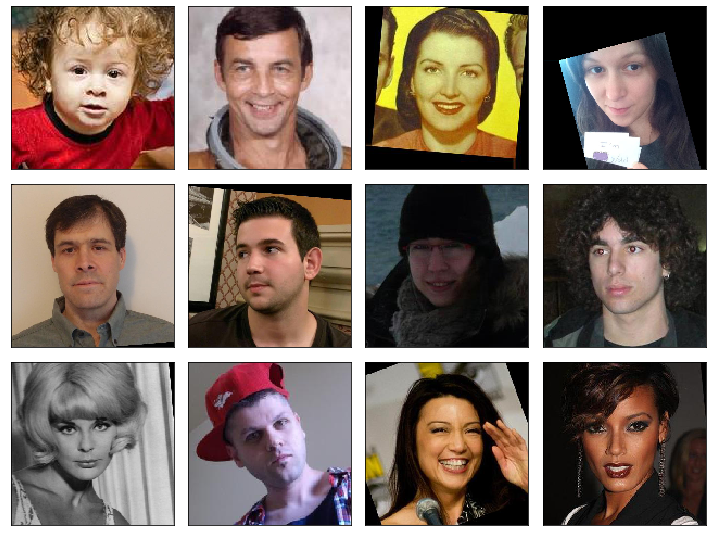

In [9]:
# выведем первые 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# 2. Обучение модели

Ниже код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, AvgPool2D
from tensorflow.keras.layers import Flatten, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    path = path + 'final_files/'
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_data = datagen.flow_from_dataframe(df, path, x_col='file_name', y_col='real_age', class_mode='raw',
                                       subset='training', target_size=(224, 224), batch_size=32, seed=424242)
    return train_data

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    path = path + 'final_files/'
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_data = datagen.flow_from_dataframe(df, path, x_col='file_name', y_col='real_age', class_mode='raw',
                                       subset='validation', target_size=(224, 224), bath_size=32, seed=424242)
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr=0.00025)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, epochs=5, steps_per_epoch=None, validation_steps=None, batch_size=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data, epochs=epochs, steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps, verbose=2, shuffle=True, batch_size=batch_size)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
2020-12-06 11:52:41.153501: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-06 11:52:41.495615: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 206.2792 - mae: 10.4461 - val_loss: 366.9876 - val_mae: 14.2049
Epoch 2/5
Epoch 3/5
178/178 - 42s - loss: 77.9374 - mae: 6.7200 - val_loss: 775.7970 - val_mae: 22.5609
178/178 - 42s - loss: 40.1917 - mae: 4.8840 - val_loss: 226.8376 - val_mae: 11.5720
Epoch 4/5
178/178 - 42s - loss: 25.1295 - mae: 3.8897 - val_loss: 123.3460 - val_mae: 8.5163
Epoch 5/5
178/178 - 42s - loss: 17.9984 - mae: 3.2733 - val_loss: 86.0801 - val_mae: 7.0298

```

# 3. Анализ обученной модели

- Загрузили таблицу с с целевым признаком возраст, названием фотографии и изучили данные: всего 7 591 наблюдений без пропусков. Средний возраст - 30 лет и 75% обладателей лиц возрастом до 40 лет. При этом имеются 4 пика: годовалые дети, примерно 23, 26 и 41-летние;
- Также извлекли фотографии из папки и объединили с таргетом, вывод первых 12 кадров показал, что данные с аугментацией: имеются резкие/вытянутые изображения, распределение по полу данной выборке пропорционально и большинство, видимо, белые;
- Подготовили 2 выборки - обучающий и валидационный в масштабе 1:3 без применения аугментации, тк фотографии изначально уже немного видоизмененные;
- За основу взяли модель ResNet50, предобученную на датасете Imagenet и скорректировали последний слой для нашей задачи, а именно оставили 1 нейрон для предсказания возраста;
- Итоговый результат MAE на валидационных данных достигнут — 7. Модель можно использовать для определения возраста покупателей.